In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 47 kB/s 
     |████████████████████████████████| 199 kB 63.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=baf49fe0b895f3ddf39f0f4fe06615c99d0cdaa6dd326f1eb827f933cfa8113f
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


### Libraries

In [2]:
# Spark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# For Encoding
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

# Models
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

# Evaluation
from pyspark.ml.evaluation import RegressionEvaluator 
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Initializing Spark

In [3]:
spark_context = SparkContext(appName="BIA678_D3")
spark_context

<SparkContext master=local[*] appName=BIA678_D3>

In [4]:
spark_session = SparkSession(spark_context)
spark_session

In [5]:
sql_context = SQLContext(spark_session.sparkContext)
sql_context

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Loading Datasets

In [6]:
data_details = spark_session.read.csv("train_dataset.csv", header=True)
data_details.show(5)
data_details.printSchema()

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [7]:
data_salaries = spark_session.read.csv("train_salaries.csv", header=True)
data_salaries.show(5)
data_salaries.printSchema()

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
+----------------+------+
only showing top 5 rows

root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)



In [8]:
# As seen in the schema above, the columne: 'salary' from data_salaries, 
# 'yearsExperience' and 'milesFromMetropolis' from data_details are string.
# These columns must be casted to numeric datatype

data_salaries = data_salaries.withColumn("salary", data_salaries.salary.cast('int'))
data_salaries.printSchema()

data_details = data_details.withColumn("yearsExperience",data_details.yearsExperience.cast('int'))
data_details = data_details.withColumn("milesFromMetropolis",data_details.milesFromMetropolis.cast('int'))
data_details.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



### Merging The Two PySpark Dataframes

In [9]:
print("Data Details Dataframe columns: ", data_details.columns)
print("Data Salaries Dataframe columns: ", data_salaries.columns)

Data Details Dataframe columns:  ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
Data Salaries Dataframe columns:  ['jobId', 'salary']


In [10]:
data = data_details.join(data_salaries, ['jobId'])

In [11]:
data.show(5)

+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|    CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407690|   COMP38|MANAGER|   DOCTORAL|CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407693|   COMP15|    CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407694|   COMP24| JUNIOR|  BACHELORS|CHEMISTRY|EDUCATION|              9|                 70|    73|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+

### Finding Missing and Duplicate Values

In [12]:
# As noticed, there are some 'NONE' values in the degree and major columns.
for column in data.columns:
  print(f"{column} column's total 'NONE' values: ", data.filter(data[column]=='NONE').count())

jobId column's total 'NONE' values:  0
companyId column's total 'NONE' values:  0
jobType column's total 'NONE' values:  0
degree column's total 'NONE' values:  236854
major column's total 'NONE' values:  532355
industry column's total 'NONE' values:  0
yearsExperience column's total 'NONE' values:  0
milesFromMetropolis column's total 'NONE' values:  0
salary column's total 'NONE' values:  0


In [13]:
# As noticed, there are no duplicate values
duplicates=data.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")
duplicates.show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|count|
+---------------+-------------------+---------+-------+------+-----+--------+-----+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+-----+



### Dataset Insights

In [14]:
# Creating SparkSQL view to perform SQL queries.
data.createOrReplaceTempView("data")

#### 1. Highest Paid Job

In [15]:
data1 = spark_session.sql('''
    SELECT salary, jobtype
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''')
data1.show()

+------+-------+
|salary|jobtype|
+------+-------+
|   301|    CFO|
|   301|    CTO|
+------+-------+



The highset paid job is for the position of CFO and CTO, having salary of $301,000 per year.

#### 2. Top 10 Highest Paying Jobs

In [16]:
data2 = spark_session.sql('''
          SELECT salary, jobtype, industry
          FROM data
          ORDER BY salary DESC
          LIMIT 10''')

print("Top 10 Highest paying job:\n")
data2.show()

Top 10 Highest paying job:

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
|   298|    CEO|     OIL|
|   294|    CEO| FINANCE|
|   294|    CEO|     OIL|
|   293|    CEO| FINANCE|
|   293|    CEO|     OIL|
|   292|    CEO| FINANCE|
|   292|    CTO| FINANCE|
|   290|    CEO|     WEB|
+------+-------+--------+



#### 3. Top 10 Lowest Paying Jobs

In [17]:
data3 = spark_session.sql('''
          SELECT salary, jobtype, industry, salary
          FROM data
          ORDER BY salary ASC
          LIMIT 10''')

print("Top 10 Least paying job:\n")
data3.show()

Top 10 Least paying job:

+------+--------------+---------+------+
|salary|       jobtype| industry|salary|
+------+--------------+---------+------+
|     0|        JUNIOR|     AUTO|     0|
|     0|        JUNIOR|      OIL|     0|
|     0|VICE_PRESIDENT|      WEB|     0|
|     0|           CTO|     AUTO|     0|
|     0|       MANAGER|  FINANCE|     0|
|    17|       JANITOR|EDUCATION|    17|
|    18|       JANITOR|EDUCATION|    18|
|    18|       JANITOR|EDUCATION|    18|
|    18|       JANITOR|EDUCATION|    18|
|    19|       JANITOR|EDUCATION|    19|
+------+--------------+---------+------+



In [18]:
# There are values in salary column that are zero, removing those.
data = data.where("salary != 0")
data.createOrReplaceTempView("data")

In [19]:
data3 = spark_session.sql('''
          SELECT salary, jobtype, industry, salary
          FROM data
          ORDER BY salary ASC
          LIMIT 10''')

print("Top 10 Least paying job:\n")
data3.show()

Top 10 Least paying job:

+------+-------+---------+------+
|salary|jobtype| industry|salary|
+------+-------+---------+------+
|    17|JANITOR|EDUCATION|    17|
|    18|JANITOR|EDUCATION|    18|
|    18|JANITOR|EDUCATION|    18|
|    18|JANITOR|EDUCATION|    18|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
|    19|JANITOR|EDUCATION|    19|
+------+-------+---------+------+



#### 4. Ranking industries based on highest average salaries.

In [20]:
data4 = spark_session.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
print("Best industries based on average salary:\n")
data4.show()

Best industries based on average salary:

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



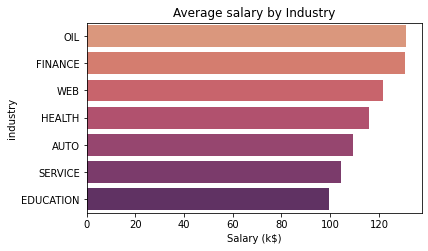

In [21]:
data4 = data4.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y='industry', x = 'average_salary', data=data4, palette='flare')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

#### 5. Finding corelation between years of experience and salary.

In [22]:
data5 = spark_session.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''')
data5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CFO|     OIL|             23|
|   301|    CTO|     OIL|             24|
|   298|    CEO|     OIL|             22|
|   294|    CEO| FINANCE|             24|
|   294|    CEO|     OIL|             19|
|   293|    CEO|     OIL|             24|
|   293|    CEO| FINANCE|             16|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CTO|     WEB|             24|
|   289|    CFO|     OIL|             23|
|   289|    CEO| FINANCE|             23|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO| FINANCE|             19|
|   287|    CEO|     OIL|             22|
|   286|    CEO| FINANCE|             24|
|   286|    CTO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
+------+-------+--------+---------

In [23]:
data5.groupBy('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [24]:
titles = ["CTO", "JUNIOR", "JANITOR", "CFO", "CEO", "MANAGER", "VICE_PRESIDENT", "SENIOR"]
data5 = data5.toPandas()

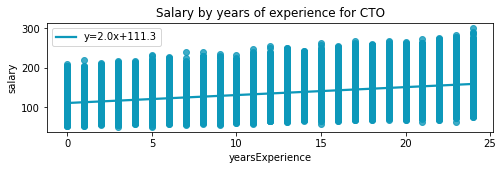

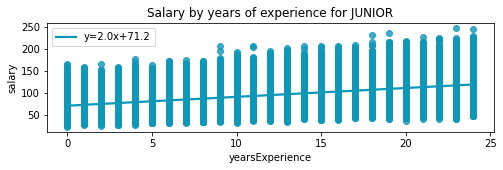

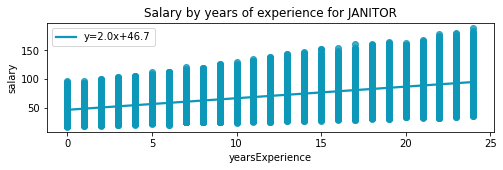

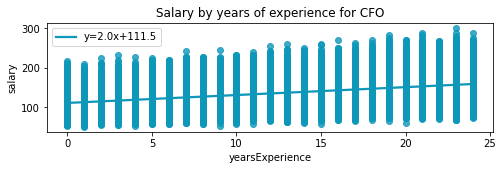

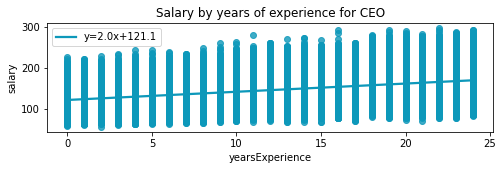

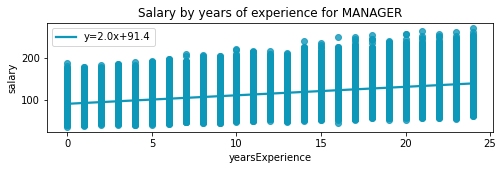

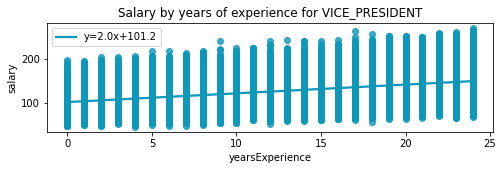

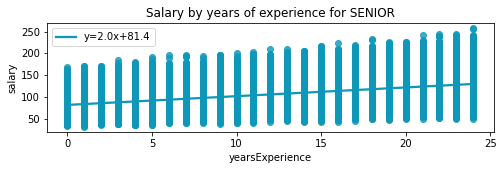

In [25]:
slope_list = []  #to save the slopes of the regression lines
intercept_list = [] #to save the intercepts of the regression lines

for title in titles:
    df_x = data5.loc[data5['jobtype']==title]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + title)
    plt.show()

#### 6. Finding corelation between degree and salary.

In [26]:
data6a = spark_session.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')
print("Top 10 Least paying job's degree:\n")
data6a.show(10)

Top 10 Least paying job's degree:

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    18|JANITOR|
|       NONE|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|       NONE|    19|JANITOR|
|       NONE|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|       NONE|    19|JANITOR|
+-----------+------+-------+
only showing top 10 rows



In [27]:
data6b = spark_session.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary desc
                  ''')
print("Top 10 Highest Paying Job's Degree:\n")
data6b.show(10)

Top 10 Highest Paying Job's Degree:

+---------+------+-------+
|   degree|salary|jobtype|
+---------+------+-------+
| DOCTORAL|   301|    CFO|
|  MASTERS|   301|    CTO|
|  MASTERS|   298|    CEO|
|BACHELORS|   294|    CEO|
| DOCTORAL|   294|    CEO|
| DOCTORAL|   293|    CEO|
| DOCTORAL|   293|    CEO|
|  MASTERS|   292|    CTO|
|BACHELORS|   292|    CEO|
| DOCTORAL|   290|    CEO|
+---------+------+-------+
only showing top 10 rows



In [28]:
# Dropping Null values
data6c = data6a.replace('NONE',None)
data6c = data6c.na.drop()

print("Number of degree holders:\n")
data6a.groupBy('degree').count().show()

Number of degree holders:

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|       NONE|236853|
|HIGH_SCHOOL|236975|
|   DOCTORAL|175362|
+-----------+------+



In [29]:
data6c = data6c.toPandas()

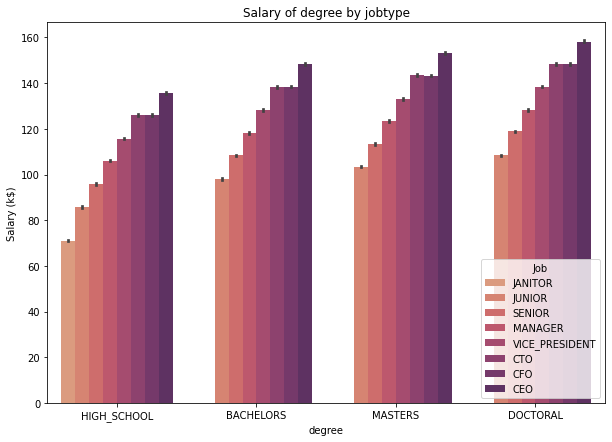

In [30]:
titles_1 = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']
degrees_list = ['HIGH_SCHOOL','BACHELORS','DOCTORAL','MASTERS']
plt.figure(figsize=(10,7))
sns.barplot(x='degree', y = 'salary', data=data6c, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

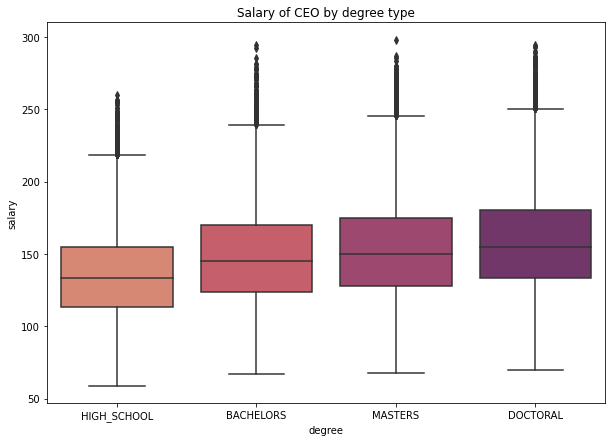

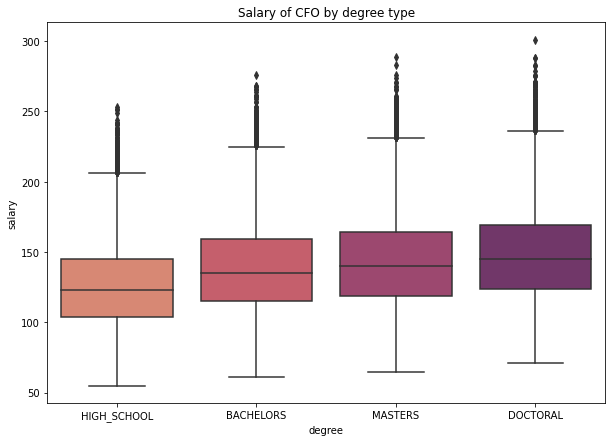

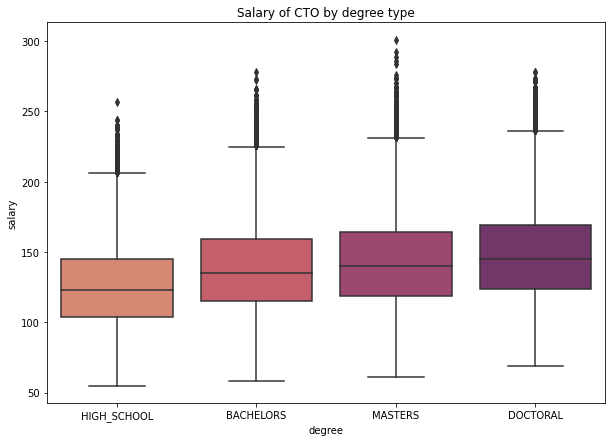

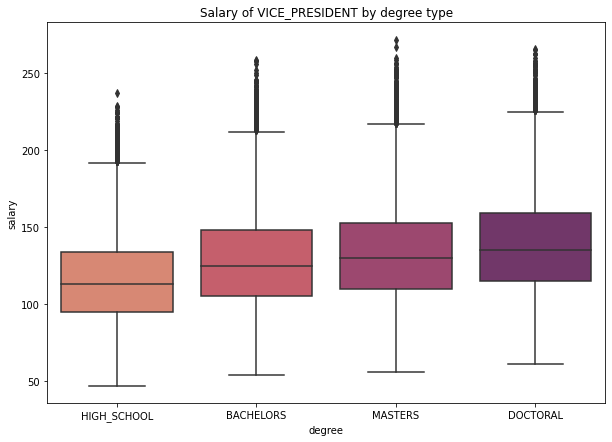

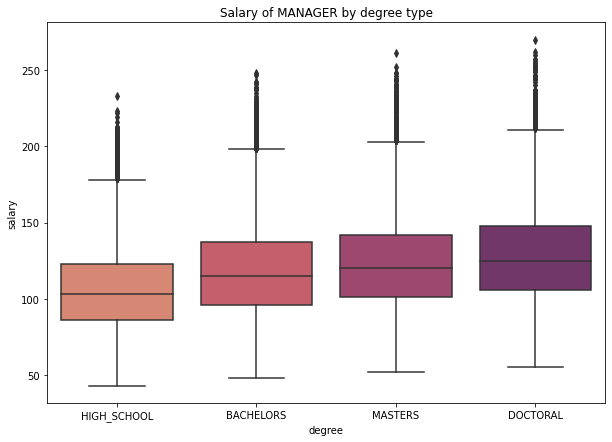

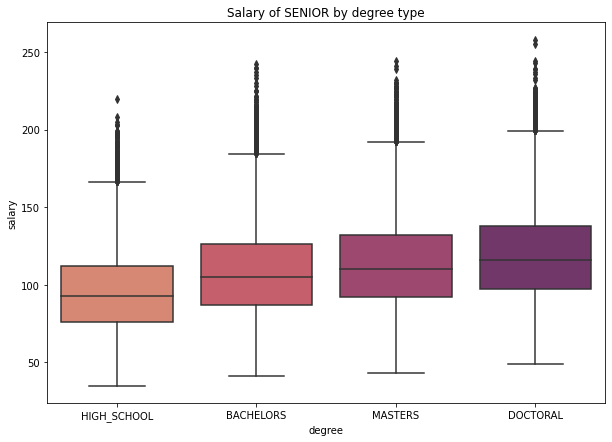

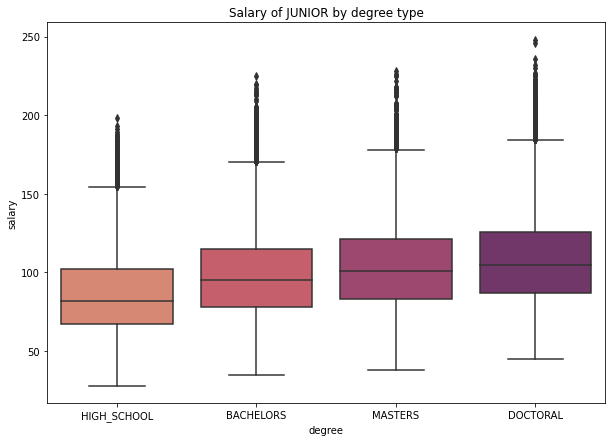

In [31]:
for title in titles_1:
  df_x1 = data6c.loc[data6c['jobtype']==title]
  plt.figure(figsize=(10,7))
  sns.boxplot(x='degree', y = 'salary', data=df_x1, palette='flare')
  plt.title('Salary of ' + title + ' by degree type')
  plt.show()

#### 7. Finding corelation between major and salary.

In [32]:
data7a = spark_session.sql('''
                  SELECT degree, salary, jobtype , major
                  FROM data
                  ORDER BY salary desc
                  ''')

data7a = data7a.replace('NONE',None)
data7a = data7a.na.drop()
print("The degree and major of people with high salaries:\n")
data7a.show(10)

print("Count of the number of people in same major:\n")
data7a.groupBy('major').count().show()

The degree and major of people with high salaries:

+---------+------+-------+-----------+
|   degree|salary|jobtype|      major|
+---------+------+-------+-----------+
|  MASTERS|   301|    CTO|ENGINEERING|
| DOCTORAL|   301|    CFO|ENGINEERING|
|  MASTERS|   298|    CEO|ENGINEERING|
| DOCTORAL|   294|    CEO|ENGINEERING|
|BACHELORS|   294|    CEO|   BUSINESS|
| DOCTORAL|   293|    CEO|    PHYSICS|
| DOCTORAL|   293|    CEO|   BUSINESS|
|  MASTERS|   292|    CTO|   BUSINESS|
|BACHELORS|   292|    CEO|   BUSINESS|
| DOCTORAL|   290|    CEO|ENGINEERING|
+---------+------+-------+-----------+
only showing top 10 rows

Count of the number of people in same major:

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|       MATH|57800|
|    COMPSCI|58382|
| LITERATURE|58684|
+-----------+-----+



In [33]:
data7c = data7a.toPandas()
data7c.head()

,degree,salary,jobtype,major
0,DOCTORAL,301,CFO,ENGINEERING
1,MASTERS,301,CTO,ENGINEERING
2,MASTERS,298,CEO,ENGINEERING
3,BACHELORS,294,CEO,BUSINESS
4,DOCTORAL,294,CEO,ENGINEERING


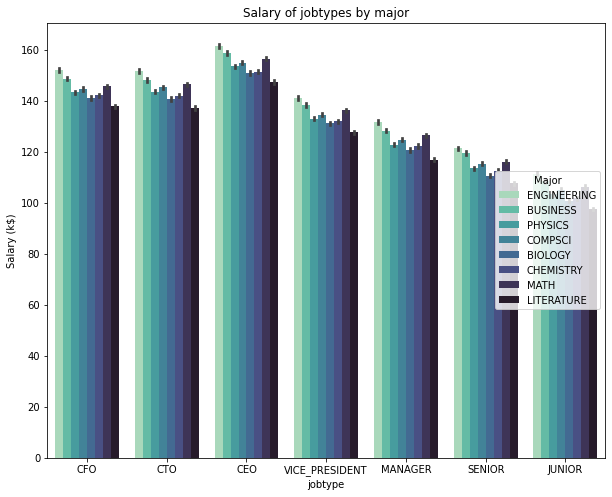

In [34]:
plt.figure(figsize=(10,8))
sns.barplot(x='jobtype', y = 'salary', data=data7c, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

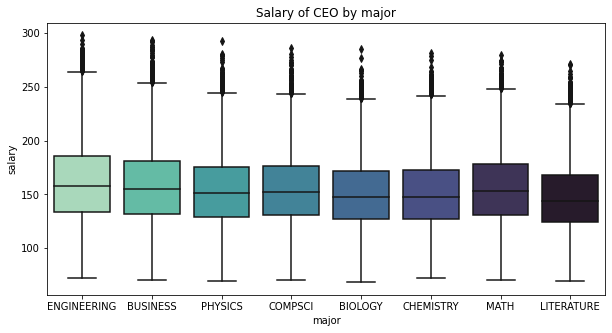

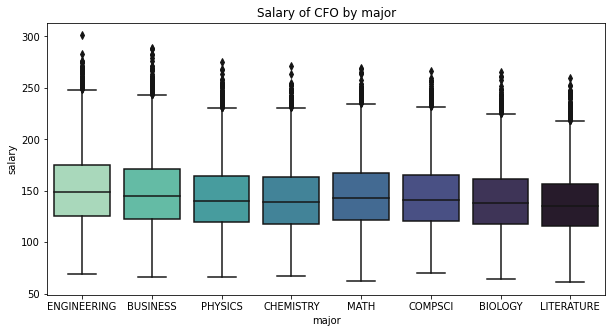

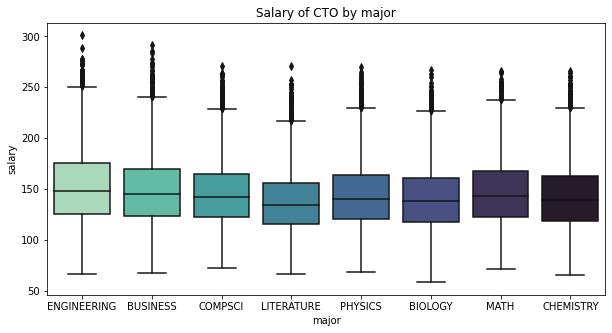

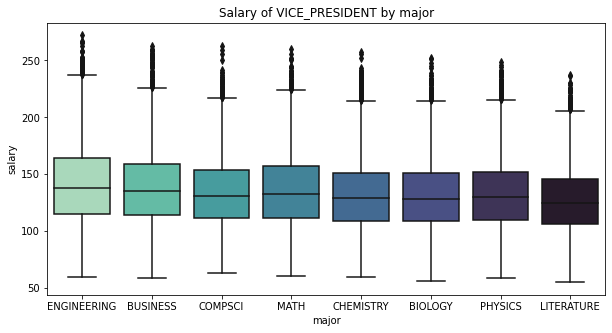

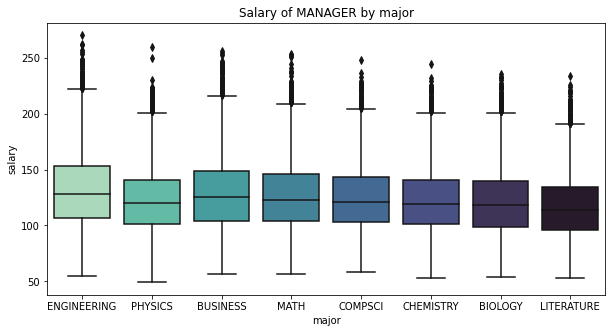

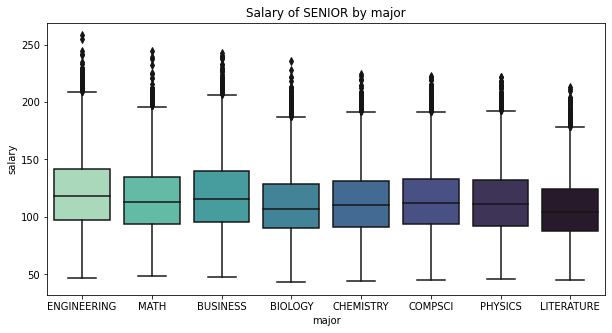

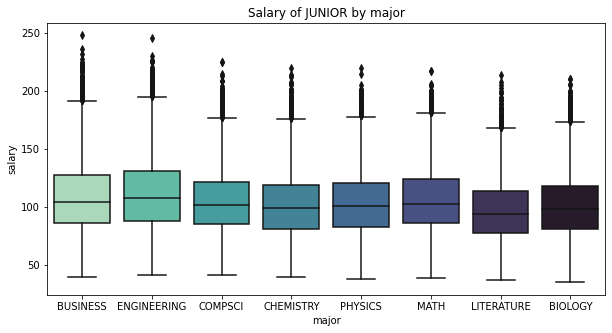

In [35]:
for title in titles_1:
  df_x = data7c.loc[data7c['jobtype']==title]
  plt.figure(figsize=(10,5))
  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')
  plt.title('Salary of ' + title + ' by major')
  plt.show()

### Predicting Salaries

In [36]:
data = data.drop('jobId')

In [37]:
columns = data.columns

In [38]:
# Encoding labels for columns representing class.
class_columns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in class_columns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in class_columns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [39]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

In [40]:
# One Hot Encoding
class_columns = ["companyId","jobType", "major", "industry"]
for categoricalCol in class_columns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in class_columns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [41]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
data = pipelineModel.transform(data)
selectedCols = ['features'] + columns
data = data.select(selectedCols)

In [42]:
data.show(1)

+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|            features|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|(86,[29,82,83,84,...|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



In [43]:
# Splitting data into training and testing sets
train, test = data.randomSplit([0.95, 0.05])

#### Linear Regression

In [44]:
lr = LinearRegression(featuresCol = 'features', labelCol='salary')

In [45]:
start = time.time()
model = lr.fit(train)
end = time.time()
lr_time = end-start

In [46]:
print("Runtime", lr_time)

Runtime 51.556031942367554


In [47]:
predicted_salary = model.transform(test)

In [48]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predicted_salary)
rmse

19.948556922182245

In [49]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predicted_salary)
r2

0.7371730858395154

In [50]:
rf_results = predicted_salary.toPandas()

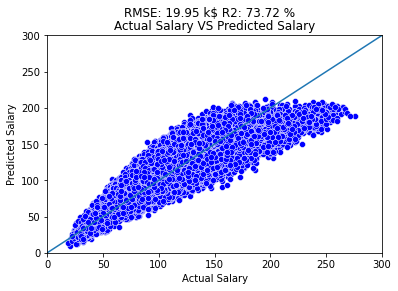

In [51]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

#### Random Forest Regressor

In [52]:
rf = RandomForestRegressor(featuresCol="features", labelCol = 'salary')

In [53]:
start = time.time()
model = rf.fit(train)
end = time.time()
rf_time = end-start

In [54]:
print("Runtime", rf_time)

Runtime 105.19237351417542


In [55]:
predicted_salary = model.transform(test)

In [56]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predicted_salary)
rmse

25.59389916028013

In [57]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predicted_salary)
r2

0.5673668671860368

In [58]:
rf_results = predicted_salary.toPandas()

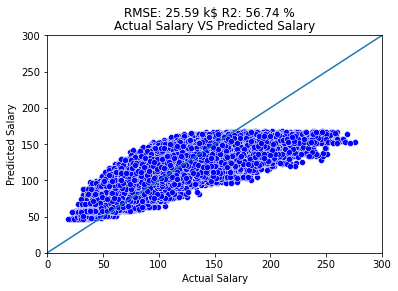

In [59]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

#### Gradient-Boosted Trees

In [60]:
# Boosting
gbt =  GBTRegressor(featuresCol="features", labelCol="salary", maxBins=20, maxDepth=12)

In [61]:
start = time.time()
model = gbt.fit(train)
end = time.time()
gbt_time = end-start

In [62]:
print("Runtime", gbt_time)

Runtime 563.0399312973022


In [63]:
predicted_salary = model.transform(test)

In [64]:
# Evaluation Root Mean Squared
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predicted_salary)
rmse

19.325911213254024

In [65]:
# Evaluation R squared
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predicted_salary)
r2

0.7533240398049992

In [66]:
rf_results = predicted_salary.toPandas()

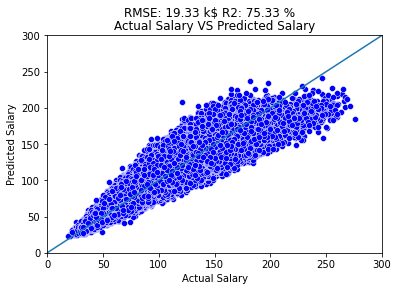

In [67]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

In [68]:
print("RMSE: {:.2f} k$ \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 19.33 k$ 
R2: 75.33 %


#### Runtime Comparision

In [69]:
import pandas as pd

In [70]:
runtime_df = [lr_time, rf_time, gbt_time]

<BarContainer object of 3 artists>

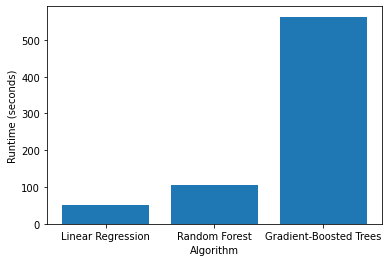

In [71]:
plt.xlabel("Algorithm")
plt.ylabel("Runtime (seconds)")
plt.bar(("Linear Regression", "Random Forest", "Gradient-Boosted Trees"), runtime_df)